In [1]:
import torch
from random import randint
from utilities import chordUtil
from utilities import dataImport
from utilities.chordUtil import *
from utilities.dataImport import *
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
import sys
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print("use_cuda")
print(use_cuda)
#use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")

use_cuda
True


In [4]:
# Init
#lenSeq = 16
lenSeq = 48
alpha = 'a3'
rootname = "inputs/jazz_xlab/"
filenames = os.listdir(rootname)
#filenames.remove(".DS_Store")
dictChord, listChord = chordUtil.getDictChord(eval(alpha))
print(len(dictChord))
print(dictChord)

121
{'G:dim': 0, 'A#:sus': 1, 'C:maj7': 2, 'G#:min': 3, 'A:min': 4, 'F#:dim': 5, 'A:7': 6, 'B:6': 7, 'C:maj': 8, 'E:sus': 9, 'G#:maj7': 10, 'E:dim': 11, 'C:min': 12, 'G:sus': 13, 'G:6': 14, 'B:sus': 15, 'D:min7': 16, 'F:maj': 17, 'A#:min7': 18, 'D:maj7': 19, 'E:aug': 20, 'E:7': 21, 'F#:7': 22, 'D:maj': 23, 'A:dim7': 24, 'C:dim7': 25, 'D#:sus': 26, 'G#:aug': 27, 'B:dim7': 28, 'D#:dim7': 29, 'G#:maj': 30, 'A#:dim': 31, 'C:7': 32, 'G#:7': 33, 'C:aug': 34, 'B:min': 35, 'G:dim7': 36, 'B:maj': 37, 'D#:min': 38, 'A#:maj7': 39, 'A#:maj': 40, 'C#:min': 41, 'G#:dim': 42, 'D#:aug': 43, 'F:dim': 44, 'G:aug': 45, 'E:maj7': 46, 'G:maj7': 47, 'E:min': 48, 'A:maj7': 49, 'G#:6': 50, 'A#:min': 51, 'A#:7': 52, 'N': 53, 'B:min7': 54, 'F:maj7': 55, 'E:min7': 56, 'B:aug': 57, 'F#:min7': 58, 'D#:maj7': 59, 'B:dim': 60, 'B:maj7': 61, 'C:6': 62, 'C#:dim7': 63, 'G:maj': 64, 'C#:6': 65, 'F:6': 66, 'D#:6': 67, 'A#:dim7': 68, 'D#:min7': 69, 'D:dim': 70, 'F:7': 71, 'F#:dim7': 72, 'B:7': 73, 'D:7': 74, 'C#:sus': 75,

In [5]:
# Create datasets
files_train ,files_test = train_test_split(filenames,test_size=0.7)
dataset_train = dataImport.ChordSeqDataset(files_train, rootname, alpha, dictChord, lenSeq)
dataset_test = dataImport.ChordSeqDataset(files_test, rootname, alpha, dictChord, lenSeq)


In [6]:
# Create generators
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(dataset_train, **params)
testing_generator = data.DataLoader(dataset_test, **params)


In [7]:
def train(local_batch, local_labels):

    optimizer.zero_grad()
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)    
    
    output, (hidden, cell_state) = lstm_nn(local_batch)

    output = output[:,-1,:]
    for i in range(len(local_batch)):
        #print(output[i].size(), local_labels[i].size())
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    
    #loss = criterion(output, local_labels_argmax)
    loss = criterion(output, local_labels)
    loss.backward()
    optimizer.step()


    return output, loss.item() / len(local_batch), correct_guess, wrong_guess

In [11]:
def test(local_batch, local_labels):
    loss = 0
    
    correct_guess, wrong_guess = 0, 0


    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    
    output, (hidden, cell_state) = lstm_nn(local_batch)

    output = output[:,-1,:]
    
    for i in range(len(local_batch)):
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    #loss = criterion(output, local_labels_argmax)
    loss = criterion(output, local_labels)

    return output, loss.item() / len(local_batch), correct_guess, wrong_guess
    

In [12]:
lstm_nn = nn.LSTM(len(dictChord), len(dictChord), num_layers = lenSeq, batch_first = True, dropout = 0.1).to(device)

all_losses = []
test_losses = []
total_loss = 0 # Reset every plot_every iters
test_loss = 0

correct_guess_train, wrong_guess_train, correct_guess_test, wrong_guess_test = 0, 0, 0, 0
accuracy_test = []
accuracy_train = []


start = time.time()

#optimizer = torch.optim.Adam(lstm_nn.parameters(), lr = 1e-4)
optimizer = torch.optim.SGD(lstm_nn.parameters(), lr = 1e-2, momentum=0.9)


criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
#criterion = nn.CrossEntropyLoss()


print_every = 5
plot_every = 5
max_epochs = 100


# Begin training

for epoch in range(1, max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        output, loss, correct_guess, wrong_guess = train(local_batch, local_labels)
        #print(loss)
        total_loss += loss
        correct_guess_train += correct_guess
        wrong_guess_train += wrong_guess

    if epoch % print_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        print('%s (%d %d%%) train, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        all_losses.append(total_loss / (plot_every ))
        accuracy_train.append(accuracy)
        total_loss = 0
        correct_guess_train, wrong_guess_train = 0, 0

        

    # Testing
    for local_batch, local_labels in testing_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output, loss, correct_guess, wrong_guess  = test(local_batch, local_labels)
        test_loss +=loss
        
        correct_guess_test += correct_guess
        wrong_guess_test += wrong_guess
        

    if epoch % print_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        print('%s (%d %d%%) test, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        test_losses.append(test_loss / (plot_every ))
        accuracy_test.append(accuracy)
        test_loss = 0
        correct_guess_test, wrong_guess_test = 0, 0



0m 47s (5 5%) train, loss : 0.0004, accuracy : 1.5006%
0m 52s (5 5%) test, loss : 0.0010, accuracy : 1.2042%
1m 39s (10 10%) train, loss : 0.0004, accuracy : 1.5475%
1m 45s (10 10%) test, loss : 0.0010, accuracy : 1.2544%
2m 32s (15 15%) train, loss : 0.0004, accuracy : 1.3599%
2m 38s (15 15%) test, loss : 0.0010, accuracy : 1.2142%
3m 25s (20 20%) train, loss : 0.0004, accuracy : 1.2427%
3m 30s (20 20%) test, loss : 0.0010, accuracy : 1.2945%
4m 18s (25 25%) train, loss : 0.0004, accuracy : 1.3599%
4m 23s (25 25%) test, loss : 0.0009, accuracy : 1.2644%
5m 10s (30 30%) train, loss : 0.0004, accuracy : 1.4302%
5m 16s (30 30%) test, loss : 0.0010, accuracy : 1.5253%
6m 3s (35 35%) train, loss : 0.0004, accuracy : 1.3599%
6m 8s (35 35%) test, loss : 0.0010, accuracy : 1.5354%
6m 56s (40 40%) train, loss : 0.0004, accuracy : 2.7433%
7m 1s (40 40%) test, loss : 0.0009, accuracy : 2.5891%
7m 48s (45 45%) train, loss : 0.0004, accuracy : 5.2755%
7m 54s (45 45%) test, loss : 0.0009, accuracy 

Loss :


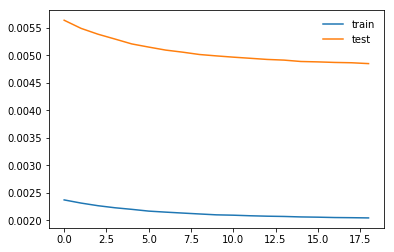

Accuracy :


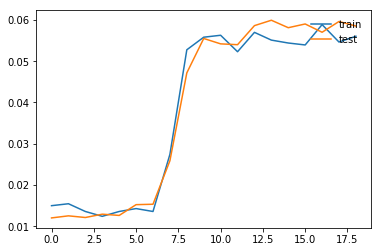

In [13]:
print("Loss :")
plt.figure()
plt.plot(all_losses, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(test_losses, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

print("Accuracy :")
plt.figure()
plt.plot(accuracy_train, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(accuracy_test, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

In [16]:
#test_sequence = ["C:maj","F:maj","C:maj","C:maj","F:maj","F:maj","C:maj","C:maj","G:maj","F:maj","C:maj","G:maj","C:maj","C:maj","F:maj","C:maj"]

test_sequence = ["C:maj","C:maj","C:maj","C:maj","F:maj","F:maj","F:maj","F:maj",
                "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                "F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj",
                "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                "G:maj","G:maj","G:maj","G:maj","F:maj","F:maj","F:maj","F:maj",
                "C:maj","C:maj","C:maj","C:maj","G:maj","G:maj","G:maj","G:maj",]

test_sequence_tensor = torch.zeros(1, len(test_sequence), len(dictChord)).to(device)
for t in range(len(test_sequence)):
    test_sequence_tensor[0, t, dictChord[test_sequence[t]]] = 1



In [17]:
generation_lenght = 120

generated_sequence = [0 for i in range(generation_lenght)]
generated_sequence[0:lenSeq] = test_sequence



for t in range(generation_lenght-lenSeq):
    if t == 0:
        output, (hidden, cell_state) = lstm_nn(test_sequence_tensor)
        generated_sequence[t+lenSeq] = listChord[torch.argmax(output[0,-1]).item()]
        
    else : 
        last_chords_output = torch.zeros(1, lenSeq, len(dictChord)).to(device)
        for i in range(lenSeq):
            last_chords_output[0, i, torch.argmax(output[0][-1]).item()] = 1
        #last_chords_output = torch.tensor([[torch.argmax(output[0][i]).item() for i in range(lenSeq)]])
        last_chords_output.to(device)

        
        output, (hidden, cell_state) = lstm_nn(last_chords_output, (hidden, cell_state))
        generated_sequence[t+lenSeq] = listChord[torch.argmax(output[0][-1]).item()]

        
for i in range(generation_lenght):
    if i%4 == 0:
        print(generated_sequence[i:i+4])
    if i == lenSeq-1 :
        print("generated :")

['C:maj', 'C:maj', 'C:maj', 'C:maj']
['F:maj', 'F:maj', 'F:maj', 'F:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['F:maj', 'F:maj', 'F:maj', 'F:maj']
['F:maj', 'F:maj', 'F:maj', 'F:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['G:maj', 'G:maj', 'G:maj', 'G:maj']
['F:maj', 'F:maj', 'F:maj', 'F:maj']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['G:maj', 'G:maj', 'G:maj', 'G:maj']
generated :
['G:7', 'G:7', 'G:7', 'G:7']
['C:maj', 'C:maj', 'C:maj', 'C:maj']
['G:7', 'G:7', 'C:maj', 'C:maj']
['G:7', 'G:7', 'G:7', 'G:7']
['C:maj', 'G:7', 'G:7', 'C:maj']
['C:maj', 'C:maj', 'G:7', 'G:7']
['G:7', 'G:7', 'C:maj', 'C:maj']
['G:7', 'G:7', 'G:7', 'C:maj']
['C:maj', 'G:7', 'G:7', 'C:maj']
['G:7', 'G:7', 'C:maj', 'G:7']
['G:7', 'C:maj', 'C:maj', 'G:7']
['C:maj', 'C:maj', 'G:7', 'C:maj']
['C:maj', 'G:7', 'G:7', 'G:7']
['G:7', 'G:7', 'C:maj', 'G:7']
['C:maj', 'G:7', 'G:7', 'C:maj']
['G:7', 'G:7', 'G:7', 'C:maj']
['G:7', 'C:maj', 'G:7', 'G:7